In [2]:
%cd sbi_stream
%load_ext autoreload
%autoreload 2

import os
import pickle
import sys

import corner
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import torch
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import gaussian_kde
from scipy.interpolate import UnivariateSpline
from ml_collections import config_dict

import datasets
from models import regressor, infer_utils

%matplotlib inline
template = '/global/homes/r/rutong/matplot_style/tri_template'
plt.style.use(template)

/global/u2/r/rutong/sbi_stream


/global/homes/r/rutong/.conda/envs/sbi/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/global/u2/r/rutong/.conda/envs/sbi/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [35]:
def approximate_arc_length(spline, x_arr):
    """
    spline: UnivariateSpline, y(x) spline
    x_arr: x points at which to compute gamma
    return gamma(x) array
    """
    y_arr = spline(x_arr)
    p2p = np.sqrt((x_arr[1:] - x_arr[:-1]) ** 2 + (y_arr[1:] - y_arr[:-1]) ** 2)
    arclength = np.concatenate(([0], np.cumsum(p2p)))
    return arclength


def project_onto_univariate_spline(data, spline, x_edges):
    """
    Computes the 1D projection of data onto a spline.
    data: (N, 2) data to project
    spline: UnivariateSpline
    x_edges:  np.ndarray, (L,) points along the curve    
    return projected data
    """

    # Compute points along the arc of the curve
    arc_edges = approximate_arc_length(spline, x_edges)

    # Compute the spline points at the x_edges
    curve_points = np.c_[x_edges, spline(x_edges)]

    # Project the data onto the curve
    nN, nF = data.shape
    nL, nF2 = curve_points.shape

    if nF != 2:
        raise ValueError("data must be (N, 2)")
    if nF2 != 2:
        raise ValueError("curve_points must be (N, 2)")
    # curve points
    p1 = curve_points[:-1, :]
    p2 = curve_points[1:, :]
    # vector from one point to next  (nL-1, nF)
    viip1 = np.subtract(p2, p1)
    # square distance from one point to next  (nL-1, nF)
    dp2 = np.sum(np.square(viip1), axis=-1)

    # data minus first point  (nN, nL-1, nF)
    dmi = np.subtract(data[:, None, :], p1[None, :, :])

    # The line extending the segment is parameterized as p1 + t (p2 - p1).  The
    # projection falls where t = [(data-p1) . (p2-p1)] / |p2-p1|^2. tM is the
    # matrix of "t"'s.
    # TODO: maybe replace by spline tangent evaluated at the curve_points
    tM = np.sum((dmi * viip1[None, :, :]), axis=-1) / dp2  # (N, nL-1)

    projected_points = p1[None, :, :] + tM[:, :, None] * viip1[None, :, :]

    # add in the nodes and find all the distances
    # the correct "place" to put the data point is within a
    # projection, unless it outside (by an endpoint)
    # or inside, but on the convex side of a segment junction
    all_points = np.empty((nN, 2 * nL - 1, nF), dtype=float)
    all_points[:, 0::2, :] = curve_points
    all_points[:, 1::2, :] = projected_points
    distances = np.linalg.norm(np.subtract(data[:, None, :], all_points), axis=-1)
    # TODO: better on-sky treatment. This is a small-angle / flat-sky
    # approximation.

    # Detect whether it is in the segment. Nodes are considered in the segment. The end segments are allowed to extend.
    not_in_projection = np.zeros(all_points.shape[:-1], dtype=bool)
    not_in_projection[:, 1 + 2 : -2 : 2] = np.logical_or(
        tM[:, 1:-1] <= 0, tM[:, 1:-1] >= 1
    )
    not_in_projection[:, 1] = tM[:, 1] >= 1  # end segs are 1/2 open
    not_in_projection[:, -2] = tM[:, -1] <= 0
    # make distances for not-in-segment infinity
    distances[not_in_projection] = np.inf

    # Find the best distance
    ind_best_distance = np.argmin(distances, axis=-1)
    
    'also return best distances'
    best_distances = np.min(distances, axis=-1)

    idx = ind_best_distance // 2
    arc_projected = arc_edges[idx] + (
        (ind_best_distance % 2)
        * tM[np.arange(len(idx)), idx]
        * (arc_edges[idx + 1] - arc_edges[idx])
    )

    return arc_projected, best_distances

In [36]:
#bin trues
def predicted_vs_true(p, t, num_bins=10):
    bin_edges = np.linspace(t.min(), t.max(), num_bins+1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    p_median = np.zeros(num_bins)
    p_stdv = np.zeros(num_bins)
    p_count = np.zeros(num_bins)
    for i in range(num_bins):
        mask = (t >= bin_edges[i]) & (t <= bin_edges[i + 1])
        if mask.sum() <= 1:
            continue
        p_median[i] = p[mask].mean(axis=0)
        p_stdv[i] = p[mask].std(axis=0)
        p_count[i] = mask.sum()
    p_error = p_stdv / (p_count)**0.5
    return bin_centers, p_median, p_error, p_stdv

In [37]:
def find_confidence_inverval(posteriors, confidence_level):
    lower_percent = (100 - confidence_level) / 2
    lower = np.percentile(posteriors, lower_percent, axis=1)
    upper_percent = 100 - (100 - confidence_level) / 2
    upper = np.percentile(posteriors, upper_percent, axis=1)
    return (lower, upper)

def calculate_coverage(truths, posteriors, confidence_level_list):
    '''
    Return coverage of the given posteriors
    '''
    coverage = list()
    for cl in confidence_level_list:
        lower, upper = find_confidence_inverval(posteriors, cl)
        percent = np.mean((lower < truths) & (truths < upper))
        coverage.append(percent)
    coverage = np.array(coverage)
    return coverage

In [3]:
# checkpoint_root = '/global/homes/r/rutong/logging/'
# run_name = 'sleepy-onion-76'
checkpoint_root = '/pscratch/sd/t/tvnguyen/stream_sbi/logging/'
run_name = 'silly-tract-83'

# checkpoint_path = f"{checkpoint_root}" \
#     f"{run_name}/lightning_logs/checkpoints/epoch=562-step=30965.ckpt"

checkpoint_path = f"{checkpoint_root}" \
    f"{run_name}/lightning_logs/checkpoints/epoch=601-step=1798174-train_loss=-3.5185-val_loss=-3.3489.ckpt"

model = regressor.Regressor.load_from_checkpoint(checkpoint_path)

/global/homes/r/rutong/.conda/envs/sbi/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/global/homes/r/rutong/.conda/envs/sbi/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.1.3


In [8]:
seed = 15
pl.seed_everything(seed)

# read in the dataset and prepare the data loader for training
# data_root = '/pscratch/sd/r/rutong/stream_sbi/datasets/2params-n1000' #not able to path.join??
# data_name = '/2params-n1000'
data_root = '/pscratch/sd/t/tvnguyen/stream_sbi/datasets/aau'
# data_dir = os.path.join(data_root, data_name) #not able to path.join??
data_processed_path = os.path.join(data_root, f"processed/{run_name}.pkl")
with open(data_processed_path, "rb") as f:
    data = pickle.load(f)

# data_labels = ['log_M_sat', 'log_rs_sat', 'vz', 'vphi', 'r_sin_phi', 'r_cos_phi']
# data = datasets.read_process_dataset(data_root, data_labels, num_bins=50, phi1_min=-20, phi1_max=-12, frac=True)

train_loader, val_loader, norm_dict = datasets.prepare_dataloader(
    data, train_frac=0.8, train_batch_size=1024, eval_batch_size=128, 
    num_workers=4, seed=seed
)

samples, labels = infer_utils.sample(model, val_loader, 5000, norm_dict=norm_dict)

[rank: 0] Seed set to 15


Reading in data from /pscratch/sd/t/tvnguyen/stream_sbi/datasets/aau/data.0.hdf5


Processing pid 0:   0%|                                                            | 0/2 [00:00<?, ?it/s]


TypeError: subsample_arrays() got multiple values for argument 'subsample_factor'

In [7]:
import importlib
importlib.reload(datasets)

<module 'datasets' from '/global/u2/r/rutong/sbi_stream/datasets/__init__.py'>

In [65]:
raw_data_dir = f'/pscratch/sd/t/tvnguyen/stream_sbi/datasets/{data_name}'
data_labels = ['log_M_sat', 'vz']
num_bins = 20
phi1_min = -20
phi1_max = 12

In [ ]:
raw = datasets.read_raw_dataset(raw_data_dir, data_labels)

Reading in data from /pscratch/sd/t/tvnguyen/stream_sbi/datasets//2params-n1000/data.0.hdf5


Processing pid 2982:  32%|██████████████▏                             | 2846/8800 [00:01<00:03, 1754.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Processing pid 8799: 100%|████████████████████████████████████████████| 8800/8800 [00:04<00:00, 1776.14it/s]


In [66]:
x, y, t, padding_mask = datasets.read_process_dataset(raw_data_dir, data_labels, num_bins, phi1_min=phi1_min, phi1_max=phi1_max, frac=True)

Reading in data from /pscratch/sd/t/tvnguyen/stream_sbi/datasets//2params-n1000/data.0.hdf5


Processing pid 8799: 100%|█████████████████████████████████████████████| 8800/8800 [00:30<00:00, 287.87it/s]


In [67]:
index = 512 #stream index

'raw data'
r_phi1 = raw[index][0]
r_phi2 = raw[index][1]
r_pm1 = raw[index][2]
r_pm2 = raw[index][3]
r_vr = raw[index][4]
r_dist = raw[index][5]

'binned data'
phi1s = t[index]

phi2s = x[index][:,0]
pm1s = x[index][:,1]
pm2s = x[index][:,2]
vrs = x[index][:,3]
dist = x[index][:,4]

phi2_std = x[index][:,5]
pm1_std = x[index][:,6]
pm2_std = x[index][:,7]
vr_std = x[index][:,8]
dist_std = x[index][:,9]

fraction = x[index][:, 10]
# count = x[index][:,10]

'filtering'
mask = phi2_std != 0

phi1s = phi1s[mask]

phi2s = phi2s[mask]
pm1s = pm1s[mask]
pm2s = pm2s[mask]
vrs = vrs[mask]
dist = dist[mask]

phi2_std = phi2_std[mask]
pm1_std = pm1_std[mask]
pm2_std = pm2_std[mask]
vr_std = vr_std[mask]
dist_std = dist_std[mask]

fraction = fraction[mask]

In [ ]:
# plt.errorbar(phi1s, pm2s, yerr=pm2_std, color='black',fmt='o', ecolor='black')
# plt.xlabel('phi1')
# plt.ylabel('pm2')

In [ ]:
from scipy.interpolate import LSQUnivariateSpline

In [71]:
def get_spline_coords(phi1, param, phi1_max, phi1_min, bins):
    'return a list of spline coords & spline function & sorted xy'
    mask = (phi1 >= phi1_min) & (phi1 <= phi1_max)
    phi1 = phi1[mask]
    param = param[mask]
    sorted_indices = np.argsort(phi1)
    sorted_phi1 = phi1[sorted_indices]
    sorted_param = param[sorted_indices]
    xy = np.transpose(np.vstack((sorted_phi1, sorted_param)))
    # splined = UnivariateSpline(sorted_phi1, sorted_param, k=5, s=200)
    knots = np.sort(phi1s[:, 0])
    knots = knots[1:-1]
    splined = LSQUnivariateSpline(sorted_phi1, sorted_param, knots)
    arc_projected, best_distances = project_onto_univariate_spline(xy, splined, bins)
    return [arc_projected, best_distances, splined, sorted_phi1, sorted_param]

In [72]:
# in xy coordinates
spline_info1 = get_spline_coords(r_phi1, r_pm1, phi1_max, phi1_min, np.linspace(phi1_min, phi1_max, 100))
arc_projected1 = spline_info1[0]
splined1 = spline_info1[2]
sorted_phi2 = spline_info1[4]
sorted_phi1 = spline_info1[3]

y_splined = splined1(sorted_phi1)
y_diff = sorted_phi2 - y_splined
spline_mean, bin_edges, _ = stats.binned_statistic(sorted_phi1, y_diff, statistic='mean', bins=num_bins)
spline_std, _, _ = stats.binned_statistic(sorted_phi1, y_diff, statistic='std', bins=num_bins)
spline_count, _, _= stats.binned_statistic(sorted_phi1, y_diff, statistic='count', bins=num_bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

Text(0, 0.5, 'pm1')

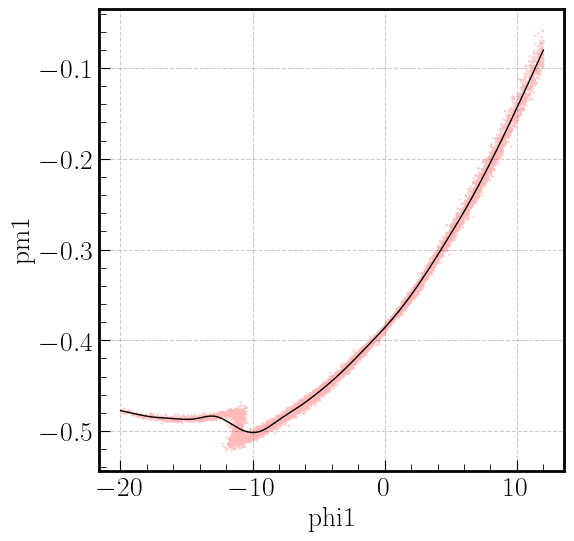

In [69]:
#binned analysis
plt.scatter(sorted_phi1, sorted_phi2, color='#FFB9B8', s=0.2)
plt.plot(sorted_phi1, splined1(sorted_phi1), color='black', linewidth=1)
# plt.errorbar(phi1s, phi2s, yerr=phi2_std, color='black',fmt='o', ecolor='black')
plt.xlabel('phi1')
plt.ylabel('pm1')

Text(0, 0.5, '$\\Delta \\mu_{1}$')

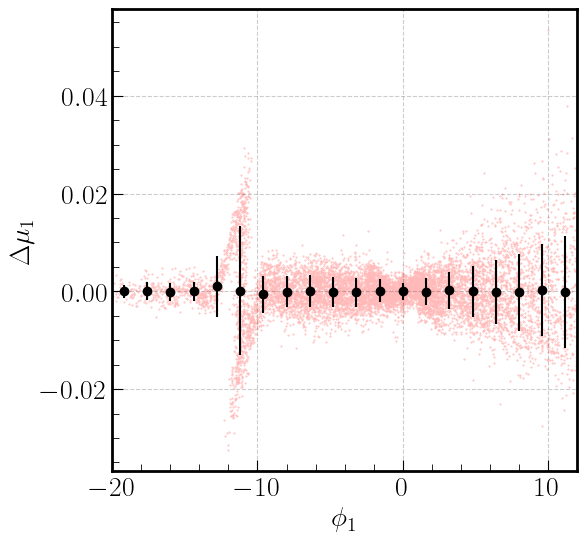

In [73]:
# plt.scatter(sorted_phi1, arc_projected, s=1)
plt.xlim(-20, 12)
# plt.ylim(-0.05, 0.05)
plt.errorbar(bin_centers, spline_mean, yerr=spline_std, color='black',fmt='o', ecolor='black')
plt.scatter(sorted_phi1, y_diff, color='#FFB9B8', s=0.2)
plt.xlabel(r'$\phi_{1}$')
plt.ylabel(r'$\Delta \mu_{1}$')

In [ ]:
# in spline coordinates
spline_info2 = get_spline_coords(r_phi1, r_pm2, phi1_max, phi1_min, np.linspace(phi1_min, phi1_max, 100))
sorted_phi2 = spline_info2[4]
arc_projected2 = spline_info2[0]
best_distances2 = spline_info2[1]
splined2 = spline_info2[2]
sorted_phi1 = spline_info2[3]
spline_mean2, bin_edges2, _ = stats.binned_statistic(arc_projected2, best_distances2, statistic='mean', bins=20)
spline_std2, _, _ = stats.binned_statistic(arc_projected2, best_distances2, statistic='std', bins=20)
spline_count2, _, _= stats.binned_statistic(arc_projected2, best_distances2, statistic='count', bins=20)
bin_centers2 = 0.5 * (bin_edges2[1:] + bin_edges2[:-1])

Text(0, 0.5, 'min distance')

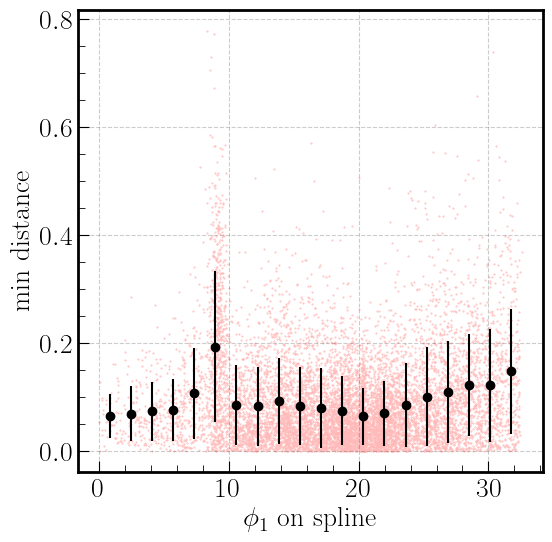

In [ ]:
# splined analysis
# plt.xlim(-20, 12)
# plt.ylim(-0.05, 0.05)
plt.scatter(arc_projected2, best_distances2, color='#FFB9B8', s=0.2)
plt.errorbar(bin_centers2, spline_mean2, yerr=spline_std2, color='black',fmt='o', ecolor='black')
plt.xlabel(r'$\phi_{1}$  on spline')
plt.ylabel('min distance')

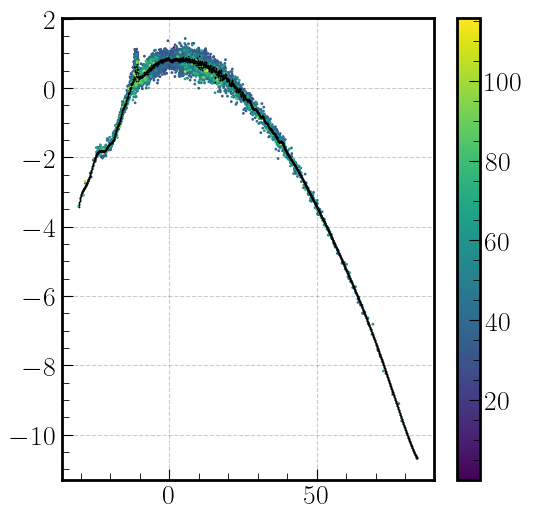

In [16]:
plt.scatter(r_phi1, r_phi2, s=1, c=arc_projected)
plt.colorbar()
plt.plot(np.linspace(phi1_min, phi1_max, 2000), splined(np.linspace(phi1_min, phi1_max, 2000)), color="k", ls="none", marker="s", markersize = 0.3)

In [56]:
samples, labels = infer_utils.sample(model, val_loader, 5000, norm_dict=norm_dict)

Sampling: 100%|█████████████████████████████████████████████████████████████████████| 14/14 [00:26<00:00,  1.87s/it]


In [58]:
index = 512

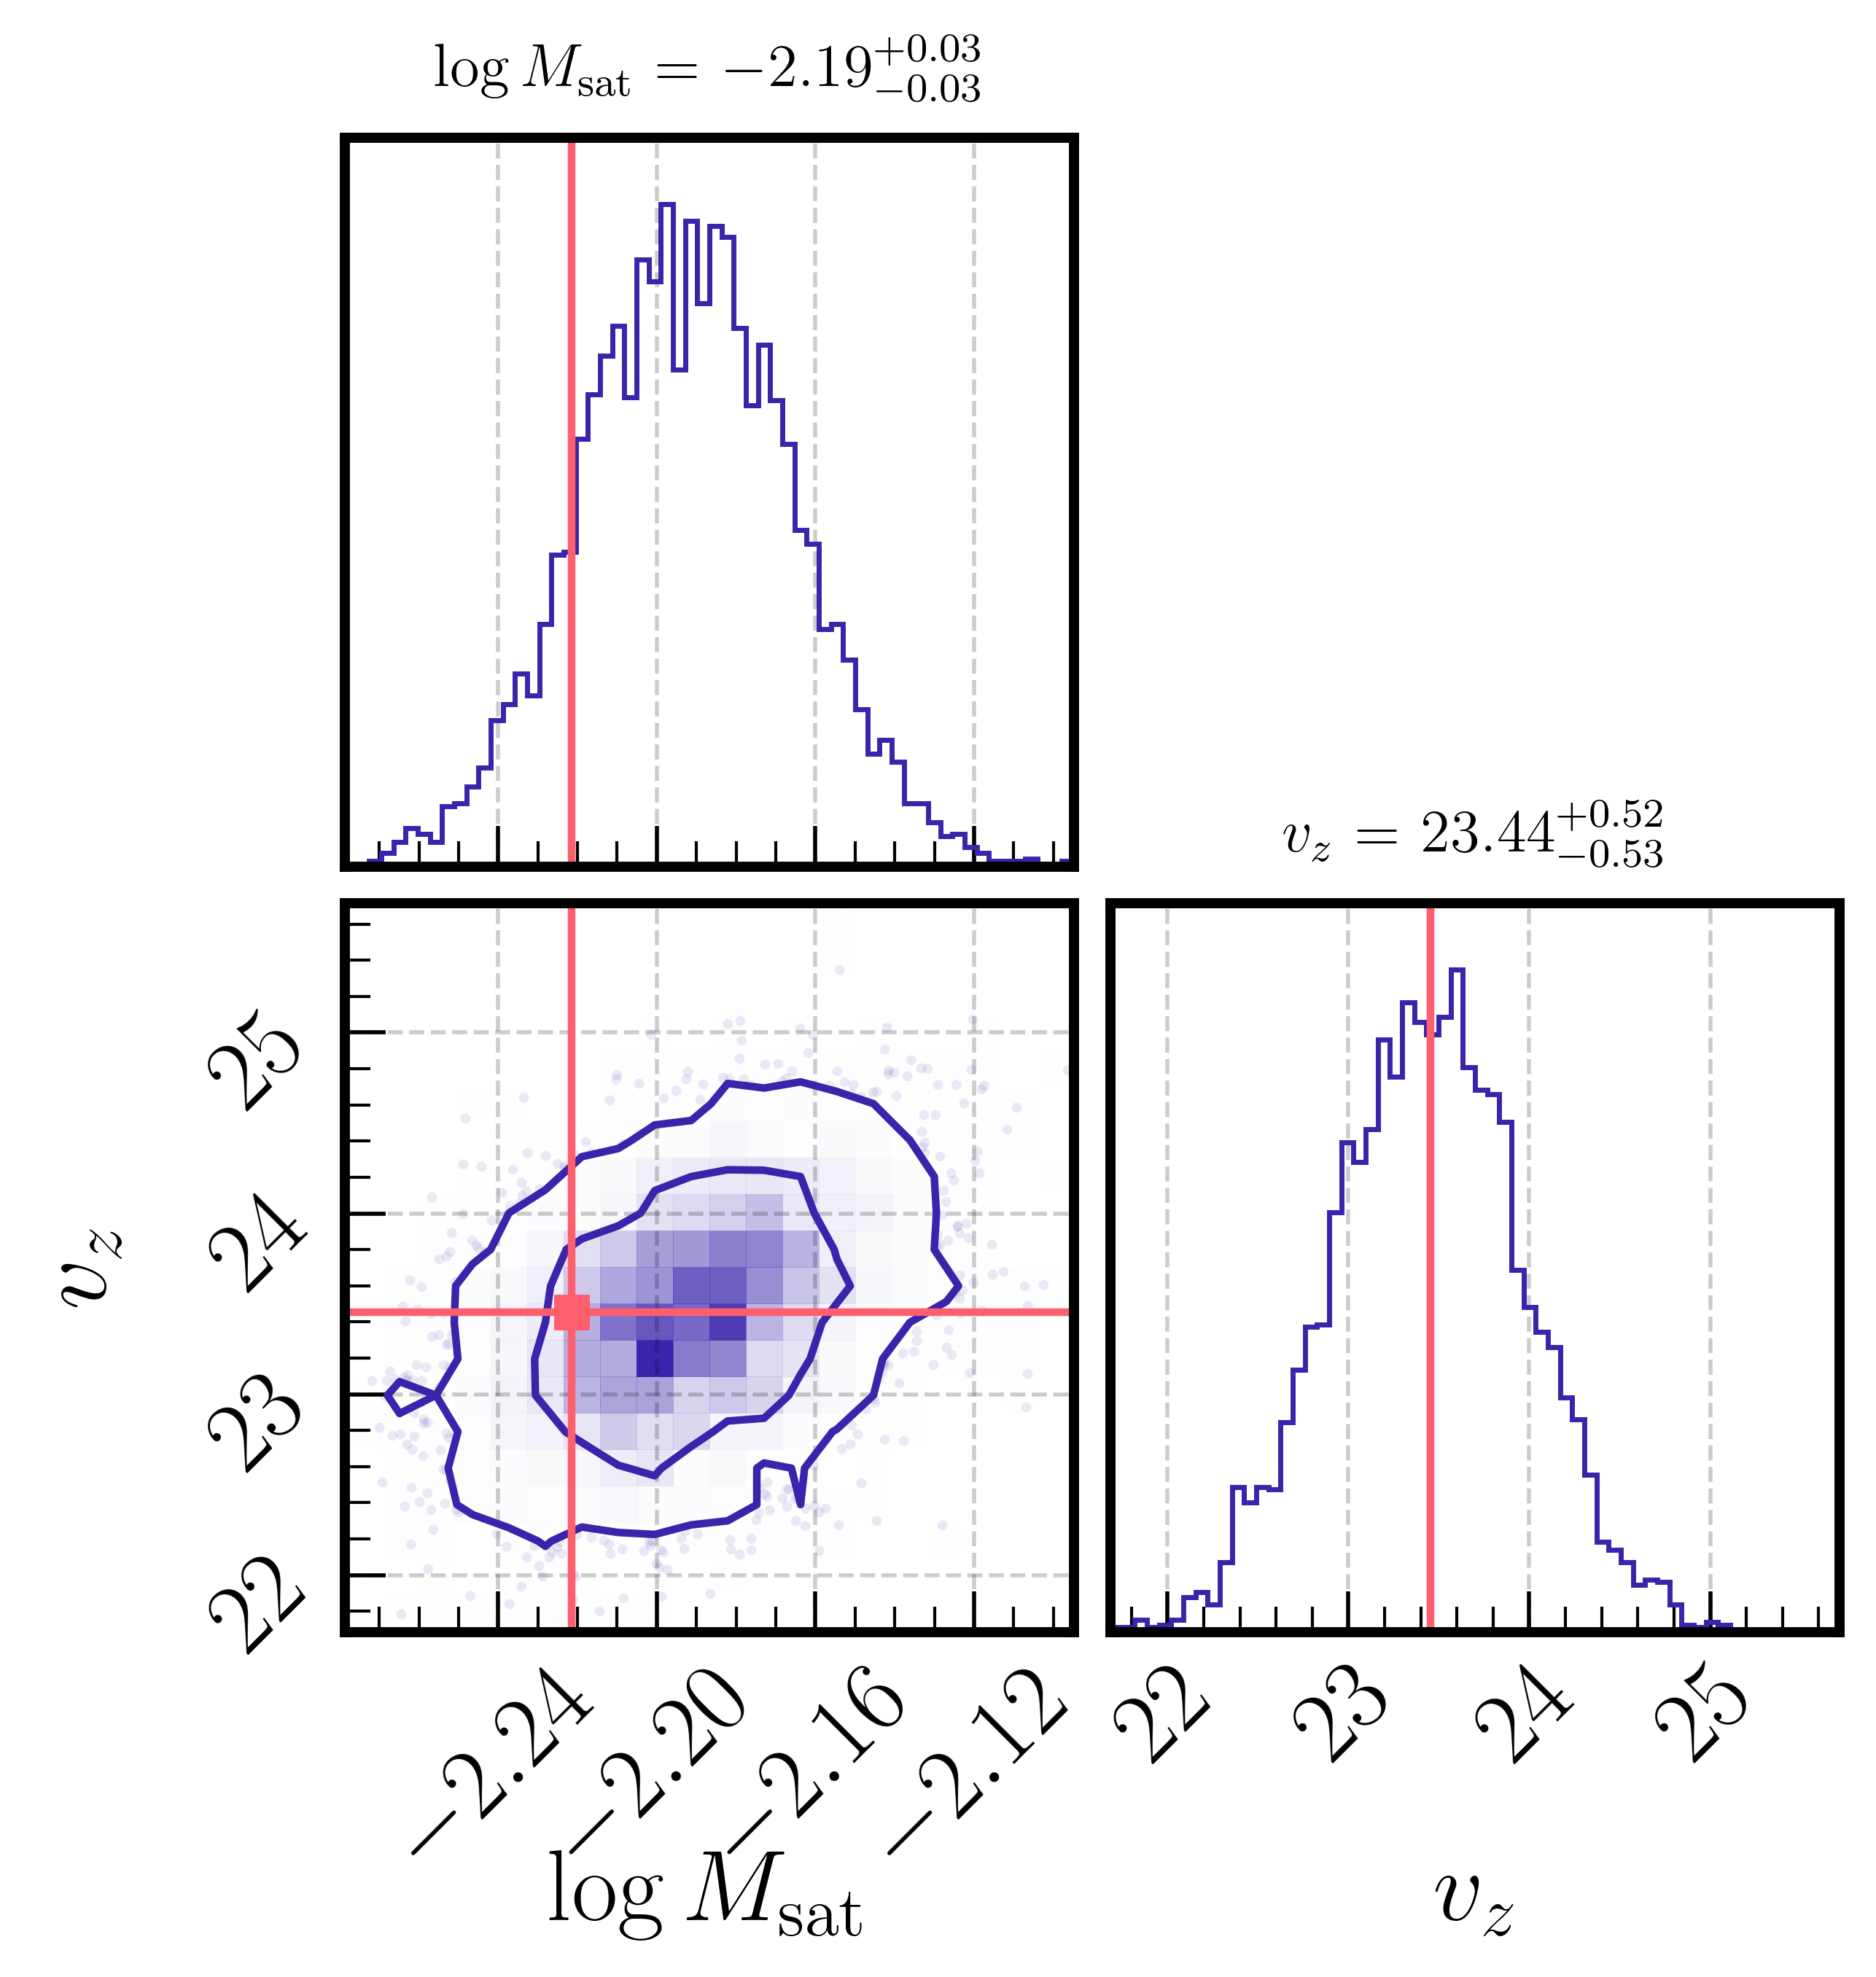

In [59]:
fig = corner.corner(
    samples[index], 
    truths=labels[index],
    truth_color='#FF5E6D',
    levels=(0.68, 0.95), 
    show_titles=True,
    labels=[r'$\log M_\mathrm{sat}$', r'$v_z$'],
    title_kwargs={"fontsize": 12},
    plot_contours=True,
    color='#3B23AB',
    hist_bin_factor = 3
)

plt.rcParams['figure.dpi'] = 500
plt.show()

In [60]:
confidence_level_list = np.linspace(5, 95, 19)
coverages = []
for i in range(2):
     coverage = calculate_coverage(labels[..., i], samples[..., i], confidence_level_list)
     coverages.append(coverage)

msat, vz = np.array(coverages)

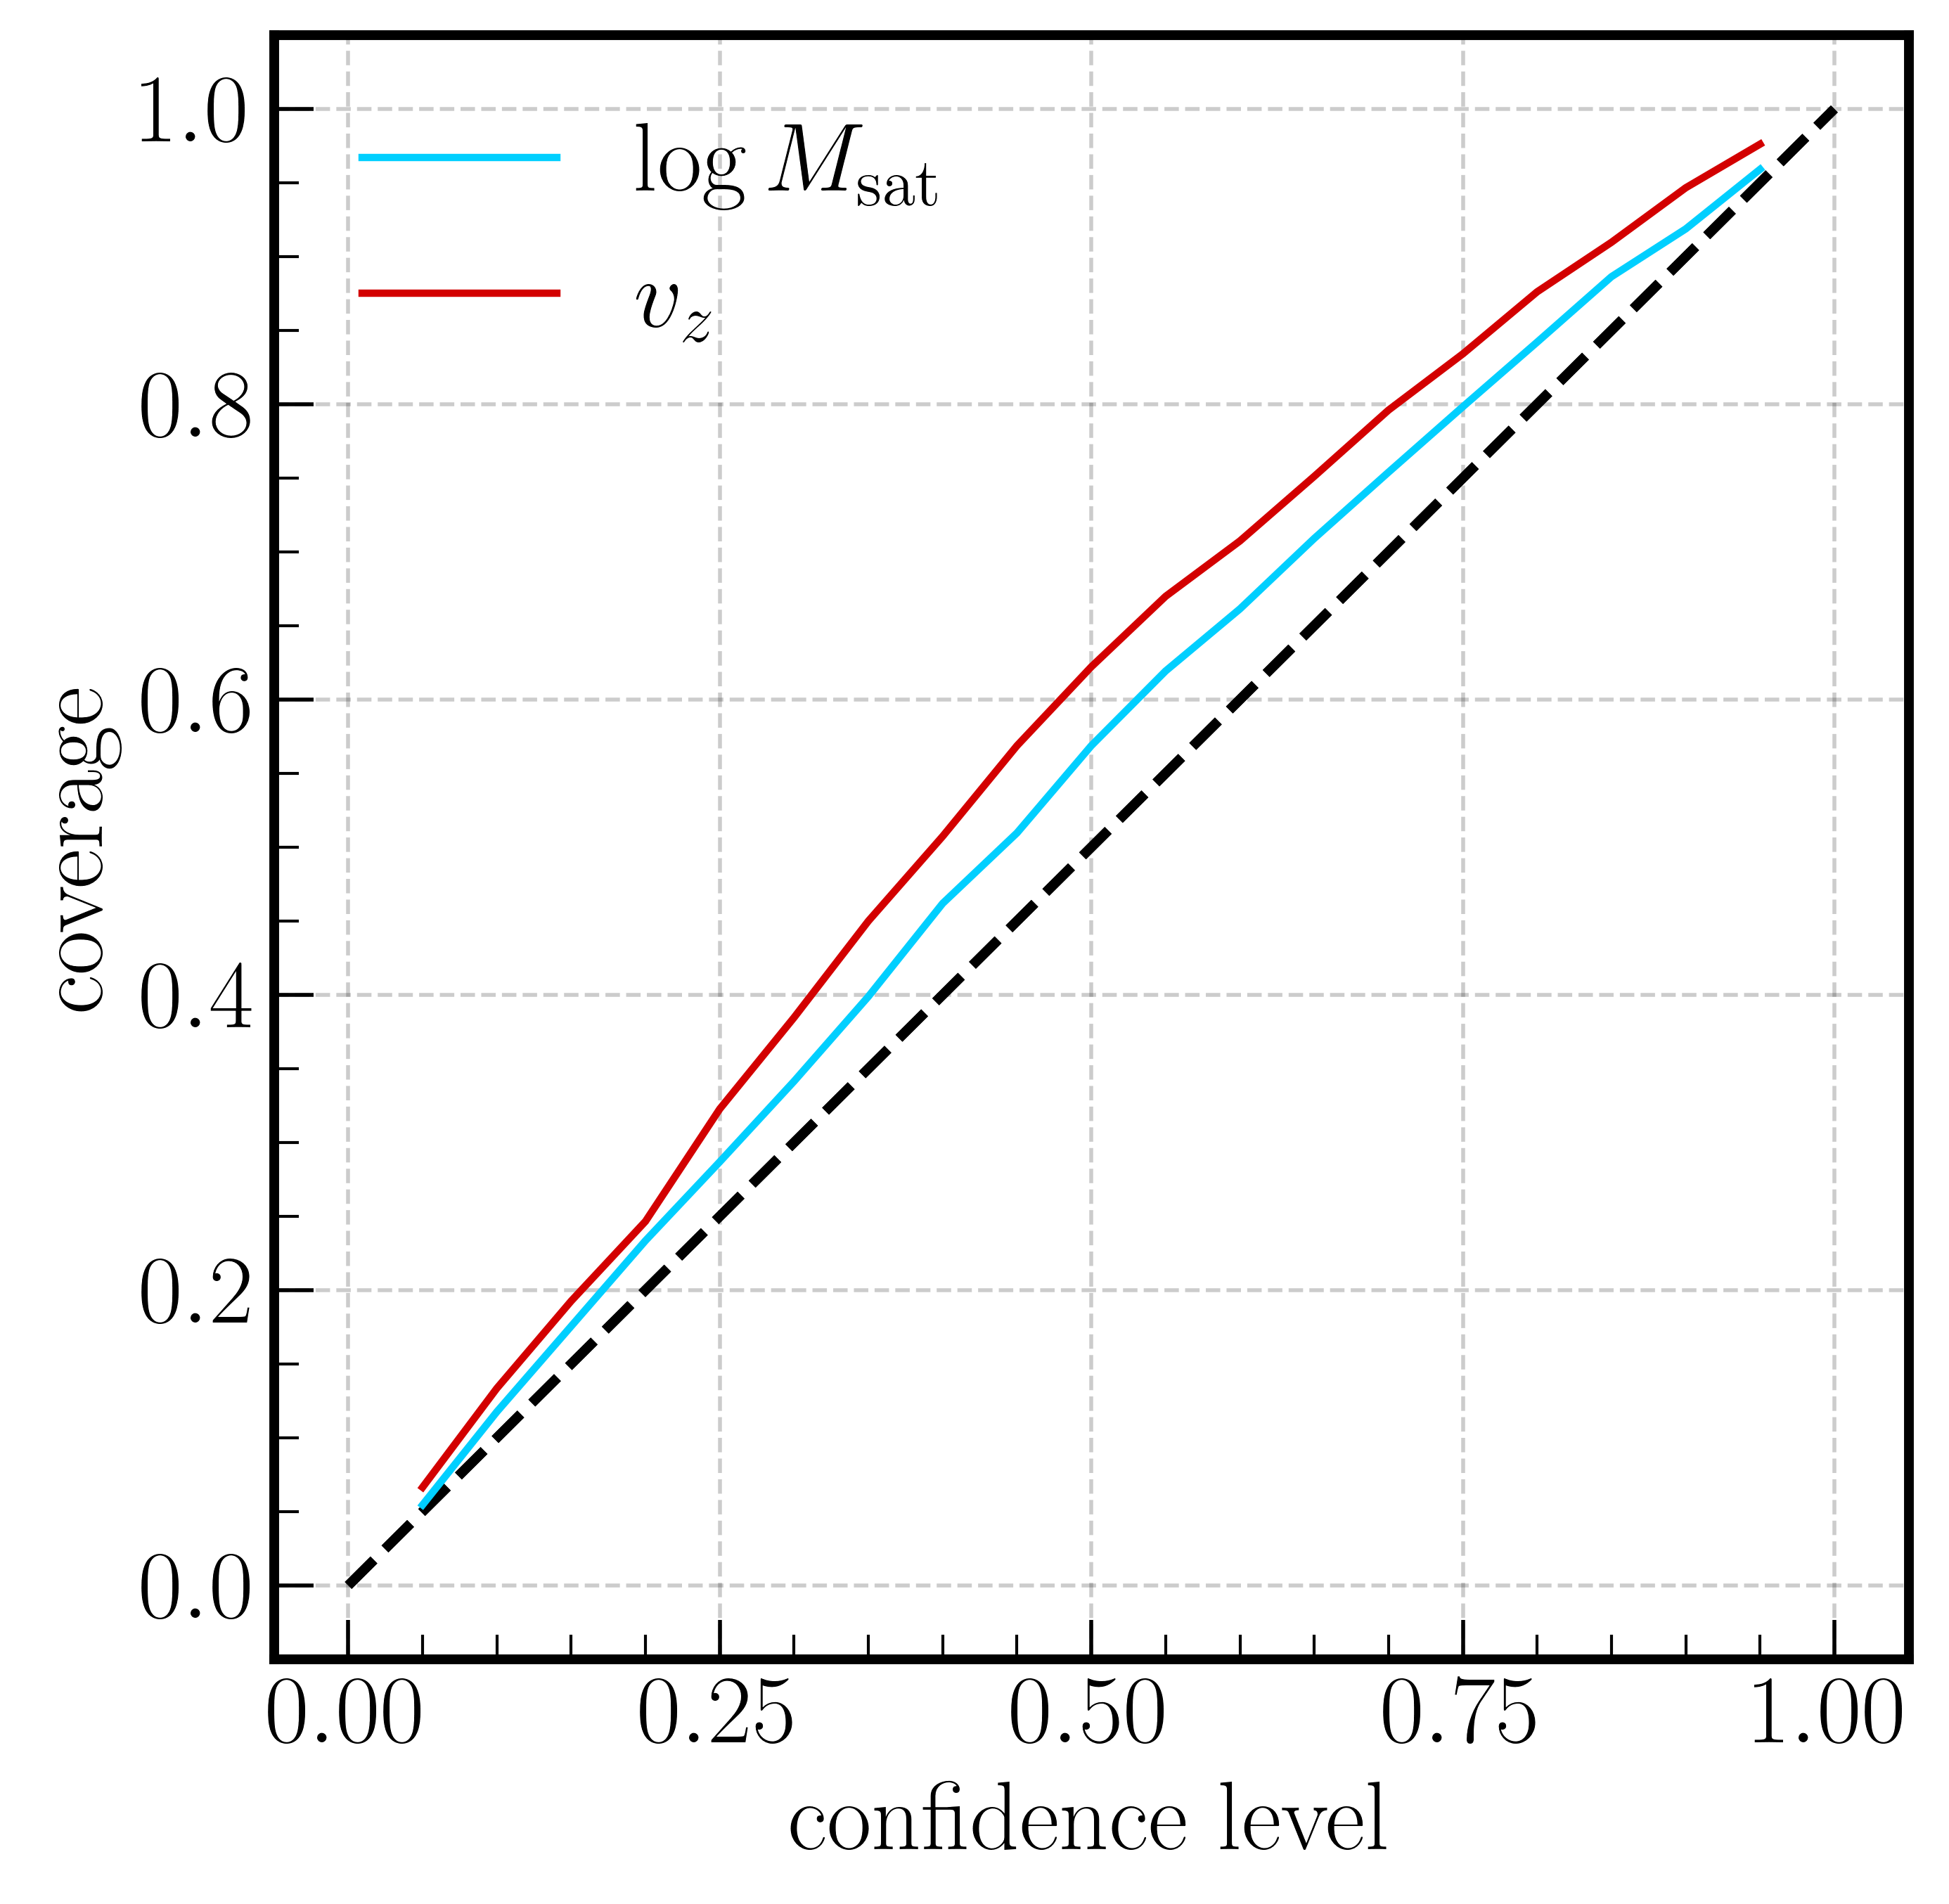

In [61]:
#coverage plot
plt.plot([(0, 0), (1, 1)], color='black', linestyle='--', linewidth=2)
plt.plot(confidence_level_list/100, msat, label=r'$\log M_\mathrm{sat}$', color = '#00CFFF')
# plt.plot(confidence_level_list/100, rsat, label=r'$\log r_\mathrm{sat}$', color = '#FF00A2')
plt.plot(confidence_level_list/100, vz, label=r'$v_z$', color = '#D30000')
# plt.plot(confidence_level_list/100, vphi, label=r'$v_\phi$', color = '#FF9000')
# plt.plot(confidence_level_list/100, r, label=r'$r$', color = '#0000FF')
# plt.plot(confidence_level_list/100, phi, label=r'$\phi$', color = '#00A400')
plt.xlabel('confidence level')
plt.ylabel('coverage')
plt.legend()
plt.show()


In [62]:
# predicted values (median) vs true values
def find_posterior_medians(posteriors):
     return [np.median(posterior) for posterior in posteriors]

predicted = []
for i in range(2):
     predicted.append(find_posterior_medians(samples[..., i]))

msat_predicted, vz_predicted = np.array(predicted)
msat_true = labels[..., 0]
vz_true = labels[..., 1]

In [69]:
msat_centers, msat_median, msat_error, msat_stdv = predicted_vs_true(msat_predicted, msat_true, num_bins=30)
vz_centers, vz_median, vz_error, vz_stdv = predicted_vs_true(vz_predicted, vz_true, num_bins=30)

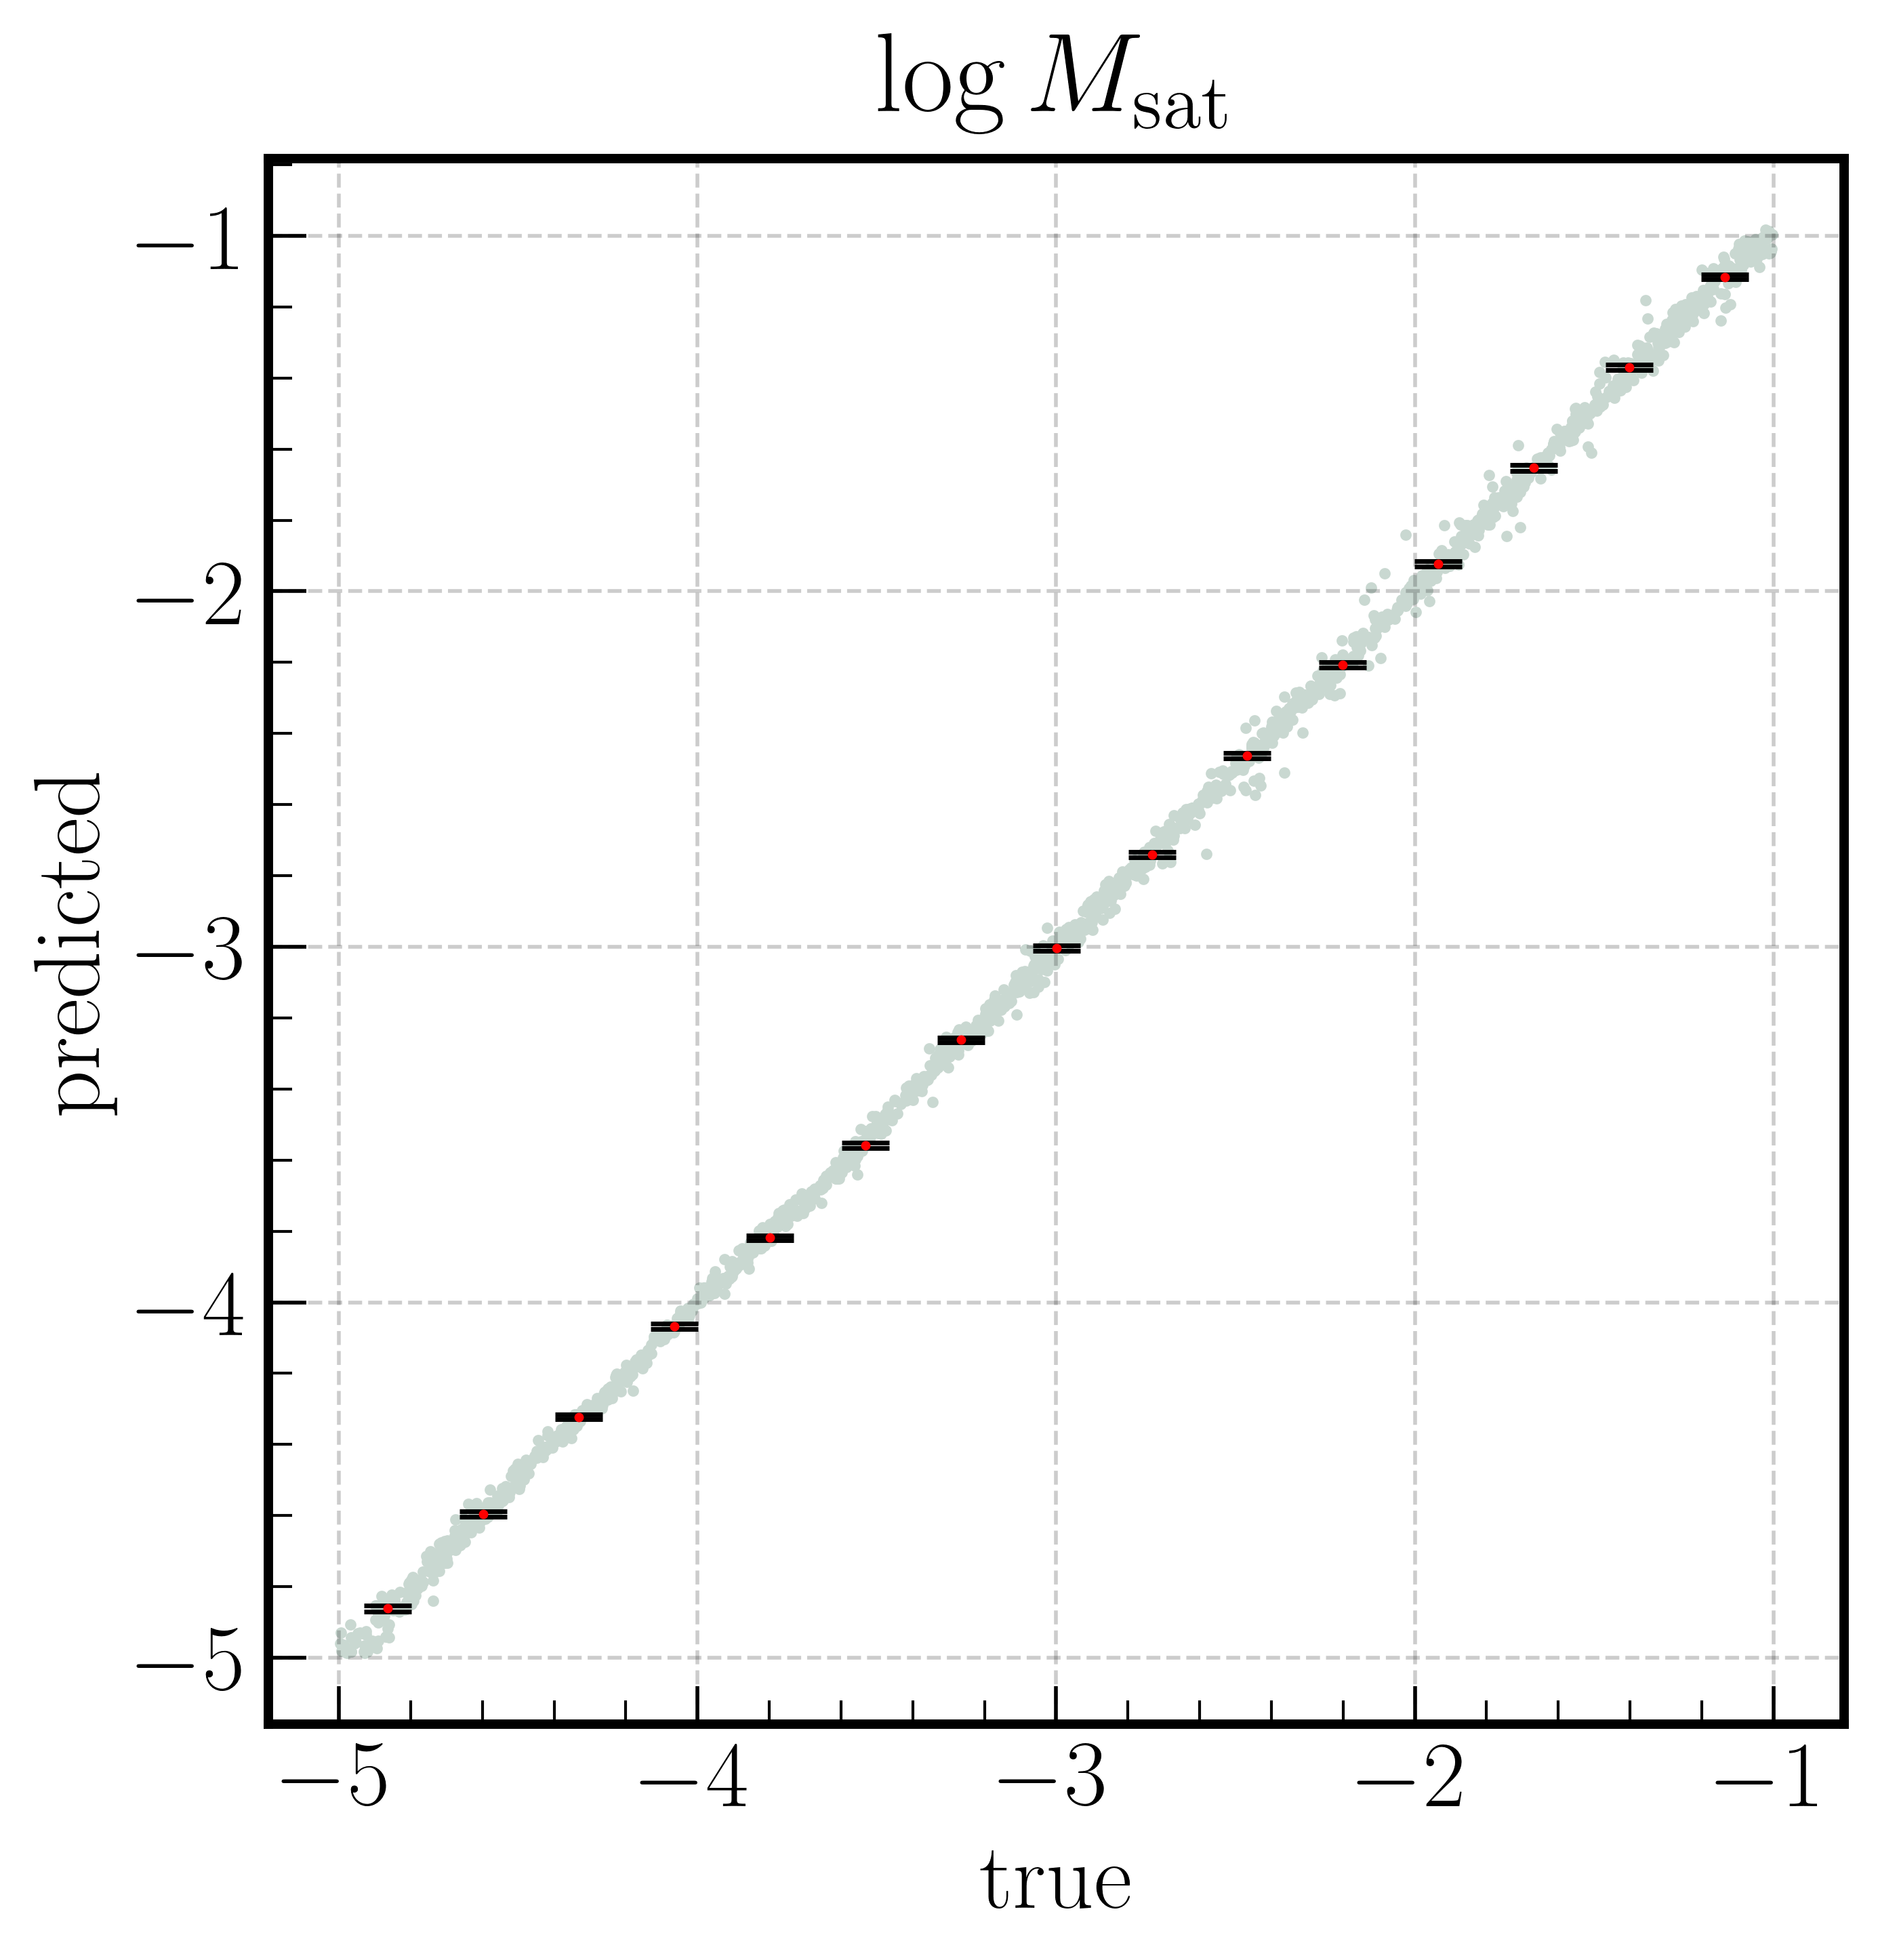

In [68]:
plt.scatter(msat_true, msat_predicted, s=2, color='#C9D8D1')
plt.errorbar(msat_centers, msat_median, yerr=msat_error, fmt='o', color='red', markersize=1, ecolor='black', capsize=5)
plt.title(r'$\log M_\mathrm{sat}$')
plt.xlabel('true')
plt.ylabel('predicted')
plt.legend()
plt.show()

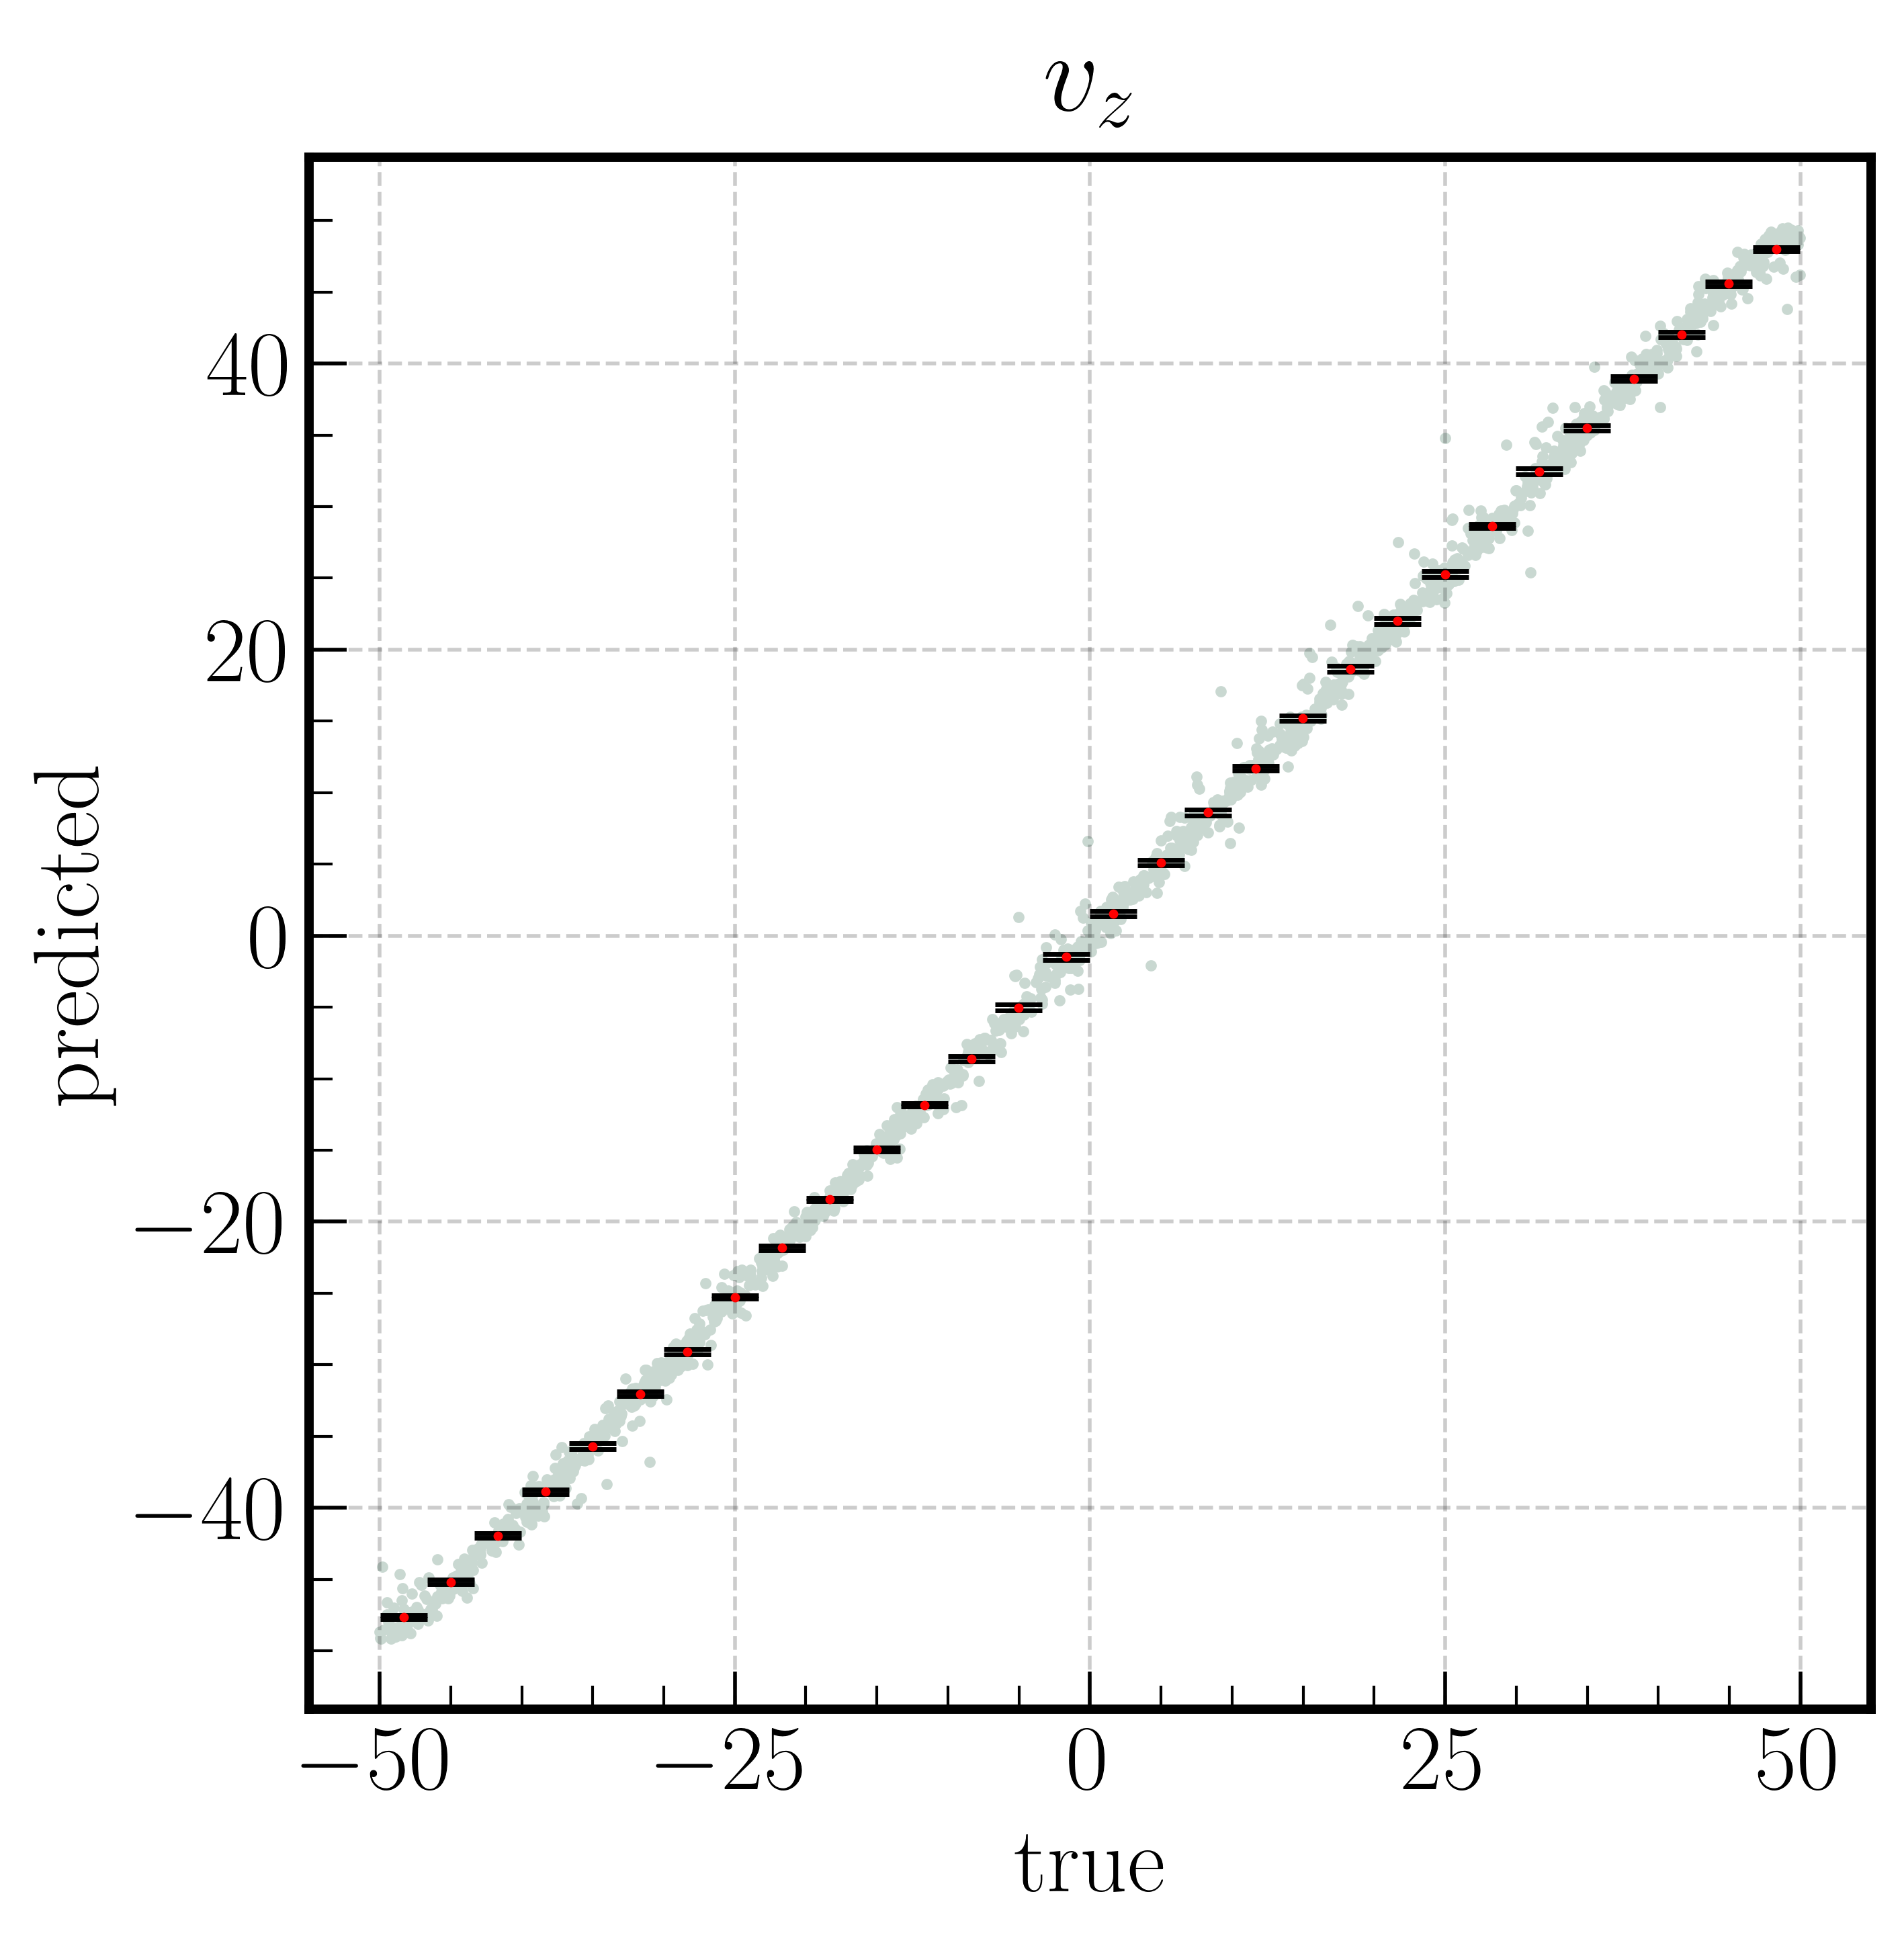

In [70]:
plt.scatter(vz_true, vz_predicted, s=2, color='#C9D8D1')
plt.errorbar(vz_centers, vz_median, yerr=vz_error, fmt='o', color='red', markersize=1, ecolor='black', capsize=5)
plt.title(r'$v_z$')
plt.xlabel('true')
plt.ylabel('predicted')
plt.legend()
plt.show()